In [154]:
import os, random, time
import xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

Importing plotly failed. Interactive plots will not work.


In [72]:
y_inven = pd.read_csv('./data/Y_inven.csv')
for i in range(0, y_inven.shape[0]):
    if np.divmod(y_inven.iloc[i, 1], 10)[0] == 0:
        y_inven.iloc[i, 1] = 'W0'+str(y_inven.iloc[i, 1])
    else:
        y_inven.iloc[i, 1] = 'W'+str(y_inven.iloc[i, 1])

In [73]:
x_sales = pd.read_csv('./data/X_Sales.csv')
x_product = pd.read_csv('./data/X_Product.csv')
x_sales = x_sales.drop(columns=x_sales.columns[0])
x_product = x_product.drop(columns=x_product.columns[0])

In [74]:
y_inven_train = y_inven[y_inven['YEAR']==2020]
y_inven_test = y_inven[y_inven['YEAR']==2021]
x_sales_train = x_sales[x_sales['YEAR']==2020]
x_sales_test = x_sales[x_sales['YEAR']==2021]
x_product_train = x_product[x_product['YEAR']== 2020]
x_product_test = x_product[x_product['YEAR']== 2021]
x_product_train = x_product_train.dropna()
x_sales_train = x_sales_train.dropna()

In [77]:
tmp_x_train = pd.merge(x_product_train, x_sales_train, how='left', on=['WW', 'YEAR'])
x_train = pd.merge(tmp_x_train, y_inven_train, how='left', on=['WW', 'YEAR'])

In [126]:
idx_rm = x_train[(x_train['WW'] == 'W26') | (x_train['WW'] == 'W29') | (x_train['WW'] == 'W30') | (x_train['WW'] == 'W31')].index
x_train = x_train.drop(idx_rm)
x_train = x_train.reset_index(drop=True)

In [6]:
w_term = []
for i in range(0, 8):    
    if i == 0 :
        w_term.append(1)
    else:
        w_term.append(0.99**i)    

In [7]:
product_col = [s for s in x_train.columns.values if 'Product' in s]
x_product = x_train[product_col].copy()
x_product = x_product.reset_index(drop=True)
product_x_col = [s for s in x_product.columns.values if 'Var' in s]
product_y_col = [s for s in x_product.columns.values if 'Var' not in s]

sales_col = [s for s in x_train.columns.values if 'Sales' in s]
x_sales = x_train[sales_col].copy()
x_sales = x_sales.reset_index(drop=True)
sales_x_col = [s for s in x_sales.columns.values if 'Var' in s]
sales_y_col = [s for s in x_sales.columns.values if 'Var' not in s]

In [26]:
sales_set = np.multiply(x_sales[sales_x_col], np.tile([w_term], x_sales.shape[0]).reshape(x_sales.shape[0], -1)).copy()

#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#model_sales = gp(kernel=kernel)
#model_sales = LR()
model_sales=xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
model_sales.fit(sales_set, x_sales[sales_y_col])
sales_hat = model_sales.predict(sales_set)


x_sales_test= x_sales_test.sort_values(['WW']).reset_index(drop=True)
sales_test = x_sales_test[sales_x_col].copy()
sales_test = np.multiply(sales_test, np.tile([w_term], sales_test.shape[0]).reshape(sales_test.shape[0], -1))

fcst_sales = model_sales.predict(sales_test)

In [35]:
product_set = np.multiply(x_product[product_x_col], np.tile([w_term], x_sales.shape[0]).reshape(x_sales.shape[0], -1)).copy()

#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#model_sales = gp(kernel=kernel)
#model_sales = LR()
model_product=xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
model_product.fit(product_set, x_product[product_y_col])
product_hat = model_product.predict(product_set)

x_product_test= x_product_test.sort_values(['WW']).reset_index(drop=True)
product_test = x_product_test[product_x_col].copy()
product_test = np.multiply(product_test, np.tile([w_term], product_test.shape[0]).reshape(product_test.shape[0], -1))

fcst_product = model_product.predict(product_test)

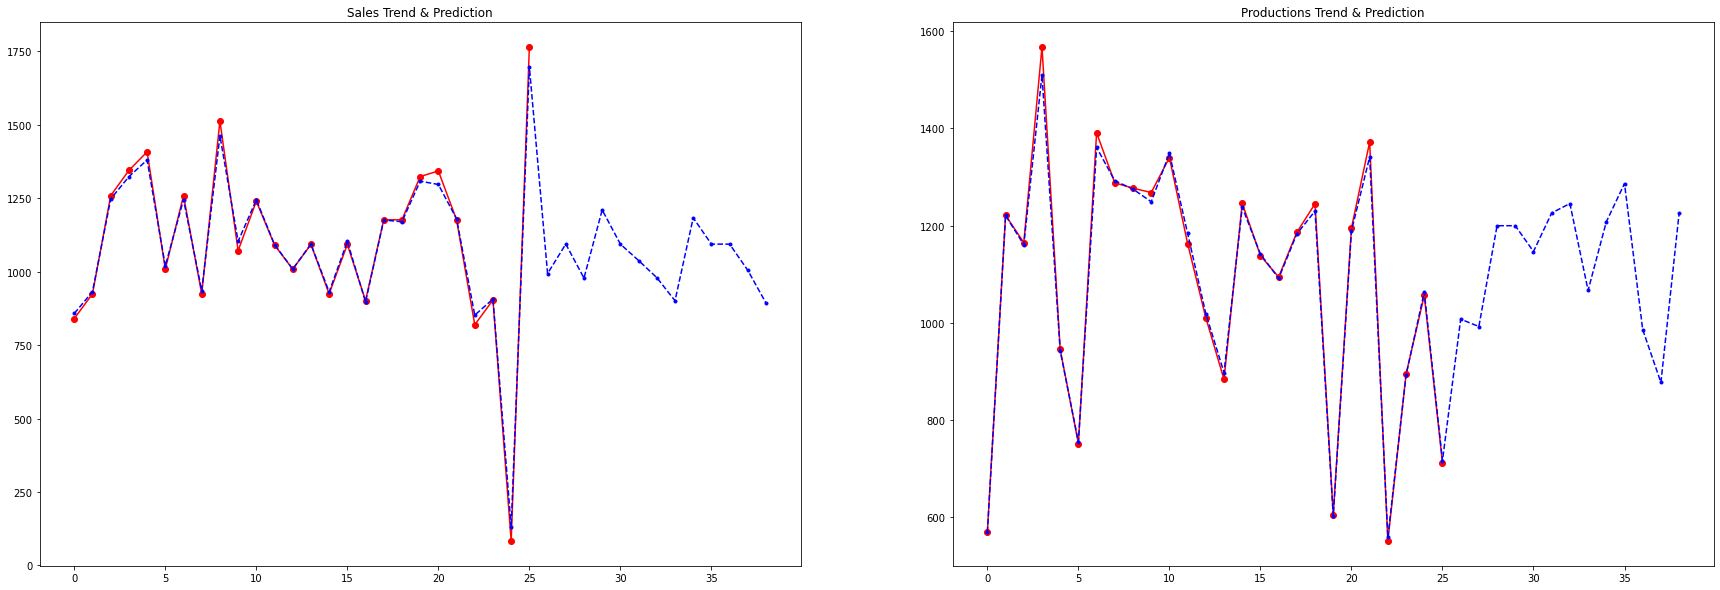

In [47]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.title("Sales Trend & Prediction")
plt.plot(x_sales[sales_y_col], color='red', marker='o')
plt.plot(np.append(sales_hat, fcst_sales), color='blue', linestyle='dashed', marker='.')
plt.subplot(1,2,2)
plt.title("Productions Trend & Prediction")
plt.plot(x_product[product_y_col], color='red', marker='o')
plt.plot(np.append(product_hat, fcst_product), color='blue', linestyle='dashed', marker='.')

In [146]:
ds = []
for i in range(0, x_train.shape[0]):
    tmp_ww =  str(x_train.iloc[i,np.where(x_train.columns == 'YEAR')[0][0]])+'-'+x_train.iloc[i,np.where(x_train.columns == 'WW')[0][0]]
    ds.append(datetime.datetime.strptime(tmp_ww+'-1', "%Y-W%W-%w"))
ds_test = []
for i in range(0, y_inven_test.shape[0]):
    tmp_ww_test =  str(y_inven_test.iloc[i,np.where(y_inven_test.columns == 'YEAR')[0][0]])+'-'+y_inven_test.iloc[i,np.where(y_inven_test.columns == 'WW')[0][0]]    
    ds_test.append(datetime.datetime.strptime(tmp_ww_test+'-1', "%Y-W%W-%w"))


In [163]:
y_train = x_train[['YEAR','WW']].copy()
y_train['ds'] = ds
y_train['y'] = x_train[inven_col[0]]
y_train['Z_sale'] = x_train['Sales']#sales_hat
y_train['Z_product'] = x_train['Product']#product_hat

y_test = y_inven_test[['YEAR','WW']]
y_test['ds'] = ds_test
y_test['y'] = y_inven_test[inven_col[0]]
y_test['Z_sale'] = fcst_sales[:9]
y_test['Z_product'] = fcst_product[:9]



In [173]:
model_time = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
#model_time.add_regressor('Z_sale', mode='multiplicative')
#model_time.add_regressor('Z_product', mode='multiplicative')

model_time.fit(y_train)#[['ds','y','Z_sale','Z_product']])
fcst_inven_train = model_time.predict(y_train)
fcst_inven = model_time.predict(y_test)#['ds','y','Z_sale','Z_product'])

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


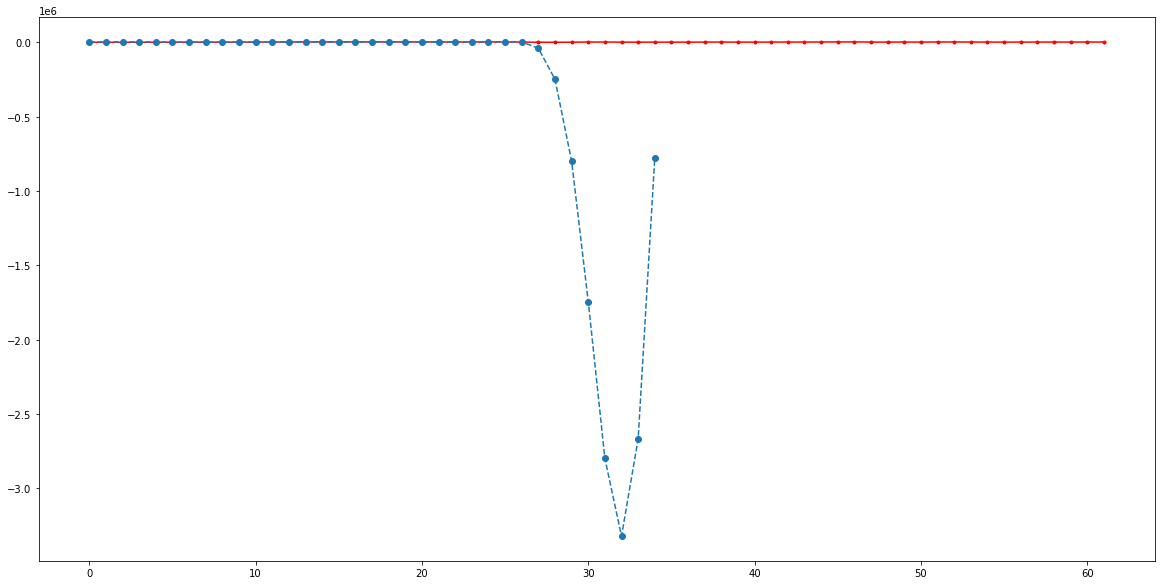

In [174]:
plt.figure(figsize=(20,10))
plt.plot(y_inven[inven_col[0]], color='red', marker='.')
plt.plot(np.append(fcst_inven_train['yhat'], fcst_inven['yhat']), marker='o', linestyle='dashed')

In [171]:
y_inven

,YEAR,WW,INVENTORY_PACK_D
0,2020,W01,376.000000
1,2020,W02,346.400000
2,2020,W03,635.714286
3,2020,W04,1003.333333
4,2020,W05,1212.285714
...,...,...,...
57,2021,W05,2279.428571
58,2021,W06,2254.857143
59,2021,W07,2428.571429
60,2021,W08,2549.285714
